In [3]:
import tool
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""
Data import
"""
asset_index = pd.read_csv("data/AIDX.csv", encoding='gbk')

# data sorting
grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)


In [5]:
"""
Parameter setup
"""

backtest_day = 30
end_date = '20230901'
num_iteration = 200

# (find turning point function) tuning parameters
num_limit = [5,10]
fraction_movement = 0.01
n_days = 7
threshold_day = 22
threshold_rate = 0.05
tolerance_days = 5

In [6]:
"""
Test run
"""

# iteration start
results = []
for i in range(0, num_iteration):
    # initialisation
    asset_info = tool.generate_random_qualified_assets(asset_dfs, num_limit=num_limit, 
                                                       fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, 
                                                       threshold_rate=threshold_rate, start_date=end_date, tolerance_days=tolerance_days)
    # asset_info = tool.generate_random_assets(asset_dfs)  # random assets without any limitation
    index_list = list(asset_info.keys())
    
    num_assets = len(index_list)
    num_views = num_assets
    
    asset_index_copy = asset_index.copy()
    asset_index_copy['TRADE_DT'] = pd.to_datetime(asset_index_copy['TRADE_DT'], format='%Y%m%d')
    asset_index_copy.sort_values(by='TRADE_DT', inplace=True)
    asset_index_copy.set_index('TRADE_DT', inplace=True)
    asset_index_copy = asset_index_copy.loc[:end_date]
    asset_index_copy = asset_index_copy.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list]
    tmp_close = asset_index_copy.tail(backtest_day)
    
    S = (tmp_close.pct_change().dropna()).cov()
    mcaps = {x:1 for x in list(S.index)}
    delta = 1
    
    try:
        mse_results = tool.mse_calculation(asset_info, S, mcaps, delta, num_assets, num_views)
    except Exception as e:
        print(e)
        continue
    
    results.append(mse_results)

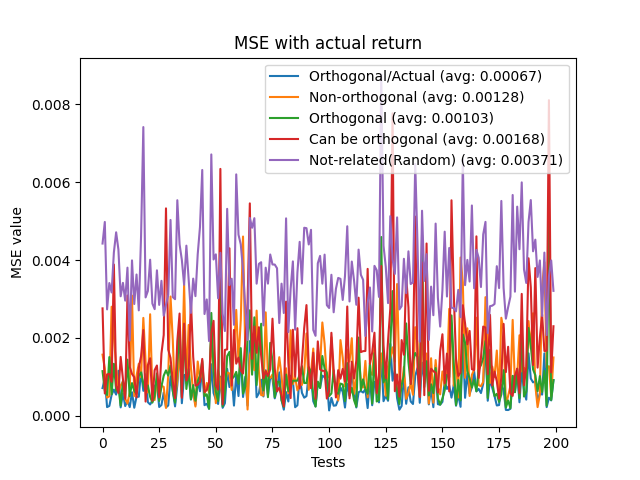

In [7]:
"""
Results output
"""

# visualisation
line_names = ['Orthogonal/Actual', 'Non-orthogonal', 'Orthogonal', 'Can be orthogonal', 'Not-related(Random)']
transposed_list = list(zip(*results))

# Plot each list as a separate line
plt.figure()
for line_data, line_name in zip(transposed_list, line_names):
    avg_value = np.mean(line_data)
    plt.plot(line_data, label=f'{line_name} (avg: {avg_value:.5f})')

# Adding labels and title
plt.xlabel('Tests')
plt.ylabel('MSE value')
plt.title('MSE with actual return')
plt.legend()

# Show the plot
plt.show()